In [1]:
import torch

In [2]:
from pathlib import Path 
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [3]:
# not available for some reason
#MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

In [4]:
path = Path("/home/mayorov/.fastai/data/mnist.pkl.gz")
path

PosixPath('/home/mayorov/.fastai/data/mnist.pkl.gz')

In [5]:
with gzip.open(path, "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [7]:
n,c = x_train.shape

In [8]:
x_train.shape, y_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), torch.Size([50000]), tensor(0), tensor(9))

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
img = x_train[0]

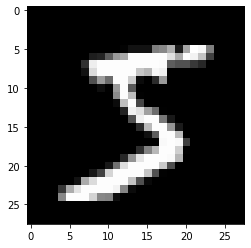

In [11]:
plt.imshow(img.view((28,28)))

## Initial python linear model

In [12]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

### matrix multiplication

In [13]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k]*b[k,j]
    return c

In [77]:
m1 = x_valid[:5]
m2 = weights

In [15]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [16]:
%time t1 = matmul(m1, m2)

CPU times: user 759 ms, sys: 2.85 ms, total: 762 ms
Wall time: 775 ms


In [17]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

In [18]:
%timeit -n 10 _ = matmul(m1, m2)

1.14 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
 torch.allclose(t1, matmul(m1, m2), rtol=1e-3, atol=1e-5)

True

## Broadcasting

### Broadcast a scalar

In [20]:
a = tensor([-10.2, 6., 7.83])

In [21]:
a > 0

tensor([False,  True,  True])

Слева тензор, справа скаляр, как может просходить такая операция? В это случае скаляр broadcasted в `[0, 0, 0]`. Это самый простой и очевидный вид бродкастинга, работает с тензорами любых рангов

In [49]:
m = tensor([[1,2,3], [4,5,6], [7,8,9]])
m+1

tensor([[ 2,  3,  4],
        [ 5,  6,  7],
        [ 8,  9, 10]])

То есть под капотом не происходит поэлементной операции, как может казаться на первый взгляд. На самом деле скаляр сначала превращается в матрицу 3х3, состоящую из единиц, а потом происходит операция сложения двух матриц.

### Broadcasting a vector to a matrix

In [50]:
c = tensor([10, 20, 30])
c

tensor([10, 20, 30])

In [51]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [52]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [53]:
m+c

tensor([[11, 22, 33],
        [14, 25, 36],
        [17, 28, 39]])

In [54]:
c + m

tensor([[11, 22, 33],
        [14, 25, 36],
        [17, 28, 39]])

Понятно, что скаляр или вектор не превращаются в матрицу, но они __ведут себя__ таким образом. The rows are given a _stride_ of 0. 

In [55]:
t = c.expand_as(m)
t

tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])

In [56]:
m + t

tensor([[11, 22, 33],
        [14, 25, 36],
        [17, 28, 39]])

In [57]:
t.storage()

 10
 20
 30
[torch.LongStorage of size 3]

In [58]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [59]:
c.unsqueeze(0)

tensor([[10, 20, 30]])

In [60]:
c.unsqueeze(0).shape

torch.Size([1, 3])

In [61]:
c.unsqueeze(1)

tensor([[10],
        [20],
        [30]])

In [62]:
c.unsqueeze(1).shape

torch.Size([3, 1])

In [63]:
c[None,:]

tensor([[10, 20, 30]])

In [64]:
c[None,:].shape

torch.Size([1, 3])

In [65]:
c[:, None]

tensor([[10],
        [20],
        [30]])

In [66]:
c[:, None].shape

torch.Size([3, 1])

In [68]:
c[:, None].expand_as(m) # expanded by columns, not by rows

tensor([[10, 10, 10],
        [20, 20, 20],
        [30, 30, 30]])

In [69]:
m + c[:, None]

tensor([[11, 12, 13],
        [24, 25, 26],
        [37, 38, 39]])

In [70]:
m + c[None, :]

tensor([[11, 22, 33],
        [14, 25, 36],
        [17, 28, 39]])

In [75]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [74]:
m.sum(dim=0)

tensor([12, 15, 18])

In [76]:
m.sum(dim=1)

tensor([ 6, 15, 24])

Основное правило такое, что бродкастится измерение с единичкой, unit axis. Поэтому 1х3 "копирует" ряды до размера 3x3, а 3х1 "копирует" колонки до размера 3х3. Ясное дело, что на самом деле копирования не происходит, всё просто хитро и оптимально переиспользуется.

### Matmul with broadcasting

Теперь можем избавиться от второго цикла в нашей функции умножения матриц

In [89]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1)*b).sum(dim=0)
    return c

In [91]:
%timeit -n 100 _ = matmul(m1, m2)

The slowest run took 5.26 times longer than the fastest. This could mean that an intermediate result is being cached.
321 µs ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
c[None, :]*c[:, None]

tensor([[100, 200, 300],
        [200, 400, 600],
        [300, 600, 900]])

In [93]:
c[None, :]@c[:, None]

tensor([[1400]])

In [95]:
(c[None, :]@c[:, None]).shape

torch.Size([1, 1])

## Einstein summation

In [98]:
# version with 3 loops:  c[i, j] += a[i,k] * b[k,j]
# version with 2 loops, vector*vector: c[i,j] = (a[i,:] * b[:, j]).sum()
def matmul(a, b): return torch.einsum('ik,kj->ij', a, b)

In [99]:
%timeit -n 10 _ = matmul(m1, m2)

The slowest run took 4.59 times longer than the fastest. This could mean that an intermediate result is being cached.
155 µs ± 84.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Pytorch operators

In [105]:
%timeit -n 10 _ = torch.matmul(m1, m2)

The slowest run took 6.32 times longer than the fastest. This could mean that an intermediate result is being cached.
56.6 µs ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
%timeit -n 10 _ = m1@m2

The slowest run took 11.18 times longer than the fastest. This could mean that an intermediate result is being cached.
18.6 µs ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
